**IMPORT LIBRARIES AND LOAD DATASET**

In [50]:
# Import libraries and packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from scipy import stats
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime, timedelta
from collections import Counter
from tqdm import tqdm_notebook
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

In [51]:
# Import dataset
df=pd.read_csv('cleaned_road_counts.csv')
df.head()

,Unnamed: 0,ROAD_ID,TIMESTAMP,ROAD_CLASS,NUMBER_VEHICLES
0,0,A3112-52-E-1.1,2019-09-06 17:00:00,Major,25.0
1,1,A3112-52-E-1.1,2019-09-06 12:00:00,Major,37.0
2,2,A3112-52-E-1.1,2019-09-06 14:00:00,Major,27.0
3,3,A3112-52-W-1.1,2019-09-06 14:00:00,Major,33.0
4,4,A3112-52-W-1.1,2019-09-06 12:00:00,Major,29.0


**DATA CLEANING AND EXPLORATION**

****a. Data Introduction****

***- Check on data dimension***

In [52]:
df.shape

(4337136, 5)

Dataset contains 4,337,136 observations with 5 variables

***- Check on variables***

In [53]:
df.columns

Index(['Unnamed: 0', 'ROAD_ID', 'TIMESTAMP', 'ROAD_CLASS', 'NUMBER_VEHICLES'], dtype='object')

****b. Data Structure and Type of Data****

***- Check on data type***

In [54]:
df.dtypes

Unnamed: 0           int64
ROAD_ID             object
TIMESTAMP           object
ROAD_CLASS          object
NUMBER_VEHICLES    float64
dtype: object

Change format of TIMESTAMP as it is currently an object

In [55]:
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])

***- Count of unique values***

In [56]:
df.nunique()

Unnamed: 0         4337136
ROAD_ID              98033
TIMESTAMP            26804
ROAD_CLASS               2
NUMBER_VEHICLES       7578
dtype: int64

Drop Unnamed: 0 as it is redundant

In [57]:
df = df.drop(columns=['Unnamed: 0'])

***- Check on unique values of categorical variables***

In [58]:
for y in df.columns:
    if(df[y].dtype == object):
        print("-----"+y+"-----")
        print(df[y].unique())

-----ROAD_ID-----
['A3112-52-E-1.1' 'A3112-52-W-1.1' 'M4-6016-W-68.1' ...
 'U-990283-C-171.11' 'C-990284-C-171.11' 'U-997007-C-164.11']
-----ROAD_CLASS-----
['Major' 'Minor']


***- Check on details of each variable***

***ROAD_ID***

In [59]:
df['ROAD_ID'].value_counts()

M56-56047-E-74.5      240
M1-46008-N-88.8       240
M1-16008-N-88.8       240
B829-967444-E-42.3    240
C-967547-W-29.3       240
                     ... 
U-953264-e-104.6        1
A606-17289-s-60.2       1
A682-56476-w-76.5       1
A3102-16955-s-68.1      1
A487-50555-s-16.4       1
Name: ROAD_ID, Length: 98033, dtype: int64

***ROAD_CLASS***

In [60]:
df['ROAD_CLASS'].value_counts(normalize=True)

Minor    0.545749
Major    0.454251
Name: ROAD_CLASS, dtype: float64

****c. Missing data****

In [61]:
df.isnull().sum()

ROAD_ID             0
TIMESTAMP           0
ROAD_CLASS          0
NUMBER_VEHICLES    15
dtype: int64

In [62]:
df[df.isnull().any(axis=1)]

,ROAD_ID,TIMESTAMP,ROAD_CLASS,NUMBER_VEHICLES
2718233,A6-80742-N-59.2,2007-05-11 12:00:00,Major,NaN
2753637,C-931829-N-23.4,2007-05-01 16:00:00,Minor,NaN
2894843,U-931046-S-92.11,2007-07-03 18:00:00,Minor,NaN
2982070,U-941407-W-76.5,2006-06-06 17:00:00,Minor,NaN
3078005,C-990281-E-82.9,2006-04-27 08:00:00,Minor,NaN
3078006,C-990281-E-82.9,2006-04-27 09:00:00,Minor,NaN
3078007,C-990281-E-82.9,2006-04-27 10:00:00,Minor,NaN
3078008,C-990281-E-82.9,2006-04-27 11:00:00,Minor,NaN
3078010,C-990281-E-82.9,2006-04-27 13:00:00,Minor,NaN
3199414,A3204-27660-E-107.6,2005-06-08 07:00:00,Major,NaN


In [63]:
df = df.dropna()

****d. Outliers / Anomalies****

****- Check on descriptive analysis of continuous variables****

In [64]:
df.describe()

,NUMBER_VEHICLES
count,4.337121e+06
mean,5.429991e+02
std,8.239447e+02
min,0.000000e+00
25%,5.400000e+01
50%,2.440000e+02
75%,6.560000e+02
max,1.090500e+04


****- Dig deep in details****

****NUMBER_VEHICLES****

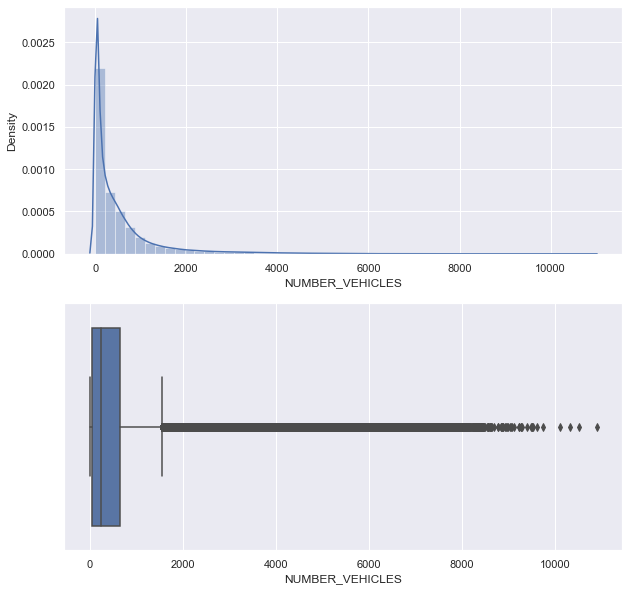

In [65]:
# Creating plot
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.distplot(df['NUMBER_VEHICLES'])
plt.subplot(2,1,2)
sns.boxplot(df['NUMBER_VEHICLES'])
# show plot
plt.show()

****e. Duplication****

In [66]:
# Check for duplication
df.duplicated().sum()

0

No duplicated values

In [67]:
# Drop
df = df.drop_duplicates()

FINAL DATA STRUCTURE

In [68]:
df.head()

,ROAD_ID,TIMESTAMP,ROAD_CLASS,NUMBER_VEHICLES
0,A3112-52-E-1.1,2019-09-06 17:00:00,Major,25.0
1,A3112-52-E-1.1,2019-09-06 12:00:00,Major,37.0
2,A3112-52-E-1.1,2019-09-06 14:00:00,Major,27.0
3,A3112-52-W-1.1,2019-09-06 14:00:00,Major,33.0
4,A3112-52-W-1.1,2019-09-06 12:00:00,Major,29.0


In [69]:
df.shape

(4337121, 4)

**PART 1: EXPLANATORY DESCRIPTIVE ANALYSIS**

***TIMESTAMP ANALYSIS***

In [70]:
df['TIMESTAMP'].value_counts()

2008-04-25 07:00:00    477
2008-04-25 11:00:00    477
2008-04-25 10:00:00    477
2008-04-25 08:00:00    477
2008-04-25 12:00:00    477
                      ... 
2004-10-09 10:00:00      1
2012-06-08 08:00:00      1
2012-06-08 18:00:00      1
2006-04-06 00:00:00      1
2002-04-19 05:00:00      1
Name: TIMESTAMP, Length: 26804, dtype: int64

Several timestamps that were observed more than others in the set, which may create bias

We can aggregate data (Sum or Average) by timestamp to see traffic as a whole for all streets

- Aggregate by sum

In [71]:
df.groupby('TIMESTAMP')['NUMBER_VEHICLES'].sum()

TIMESTAMP
2000-03-17 07:00:00    116479.0
2000-03-17 08:00:00    139183.0
2000-03-17 09:00:00    107061.0
2000-03-17 10:00:00     96908.0
2000-03-17 11:00:00     99507.0
                         ...   
2019-11-07 14:00:00      1771.0
2019-11-07 15:00:00      1855.0
2019-11-07 16:00:00      2050.0
2019-11-07 17:00:00      2055.0
2019-11-07 18:00:00      2022.0
Name: NUMBER_VEHICLES, Length: 26804, dtype: float64

<AxesSubplot:title={'center':'Total traffic by timeframe in UK'}, xlabel='TIMESTAMP', ylabel='Sum of all traffic'>

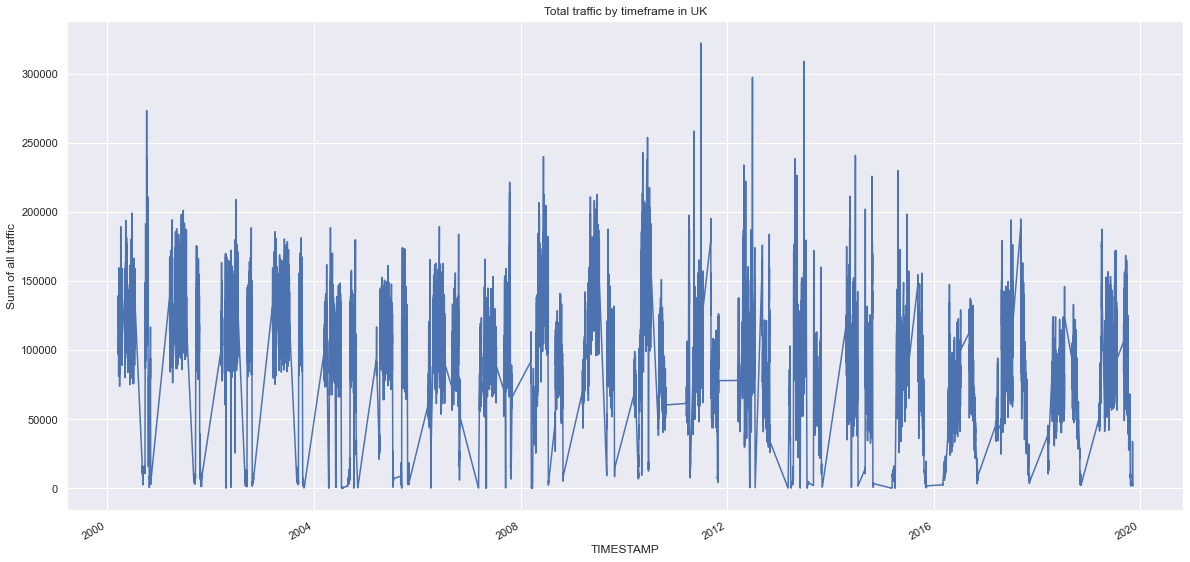

In [72]:
df.groupby('TIMESTAMP')['NUMBER_VEHICLES'].sum().plot(figsize=(20, 10), title='Total traffic by timeframe in UK',ylabel ='Sum of all traffic')


In [73]:
byroadclass = df.groupby(['ROAD_CLASS','TIMESTAMP'])['NUMBER_VEHICLES'].sum().reset_index().rename(columns={'NUMBER_VEHICLES':'Total Traffic'})
byroadclass

,ROAD_CLASS,TIMESTAMP,Total Traffic
0,Major,2000-03-17 07:00:00,108655.0
1,Major,2000-03-17 08:00:00,128281.0
2,Major,2000-03-17 09:00:00,98990.0
3,Major,2000-03-17 10:00:00,89665.0
4,Major,2000-03-17 11:00:00,91889.0
...,...,...,...
52011,Minor,2019-11-04 14:00:00,806.0
52012,Minor,2019-11-04 15:00:00,874.0
52013,Minor,2019-11-04 16:00:00,1063.0
52014,Minor,2019-11-04 17:00:00,1142.0


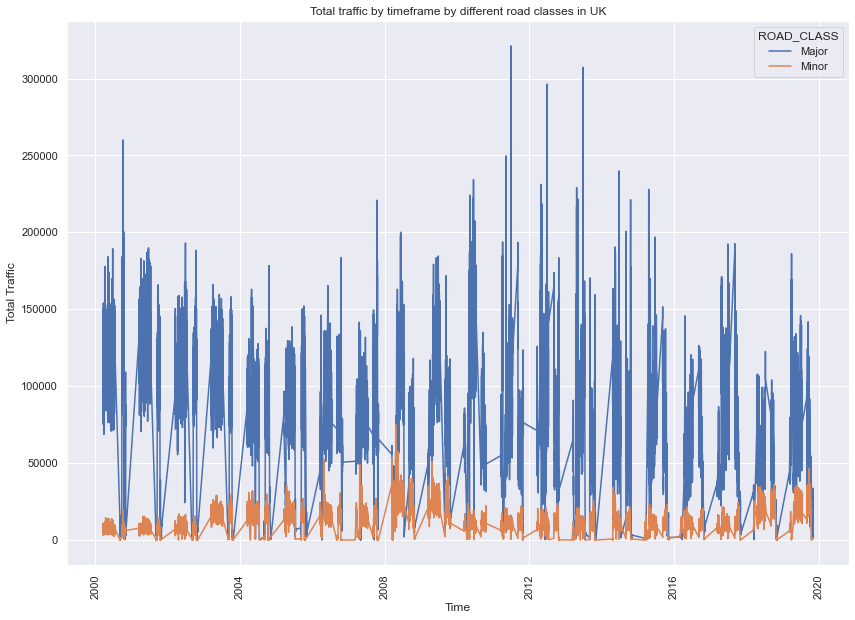

In [74]:
sns.set(rc={'figure.figsize':(14,10)})

ax = sns.lineplot(data=byroadclass, x ='TIMESTAMP', y = 'Total Traffic',
                  hue='ROAD_CLASS',legend='full')

plt.ylabel('Total Traffic')
plt.xlabel('Time')
plt.title('Total traffic by timeframe by different road classes in UK')
plt.xticks(rotation=90)
plt.show()

- Aggregate by average

In [75]:
df.groupby('TIMESTAMP')['NUMBER_VEHICLES'].mean()

TIMESTAMP
2000-03-17 07:00:00    746.660256
2000-03-17 08:00:00    892.198718
2000-03-17 09:00:00    686.288462
2000-03-17 10:00:00    621.205128
2000-03-17 11:00:00    637.865385
                          ...    
2019-11-07 14:00:00    442.750000
2019-11-07 15:00:00    463.750000
2019-11-07 16:00:00    512.500000
2019-11-07 17:00:00    513.750000
2019-11-07 18:00:00    505.500000
Name: NUMBER_VEHICLES, Length: 26804, dtype: float64

<AxesSubplot:title={'center':'Average traffic by timeframe in UK'}, xlabel='TIMESTAMP', ylabel='Mean traffic'>

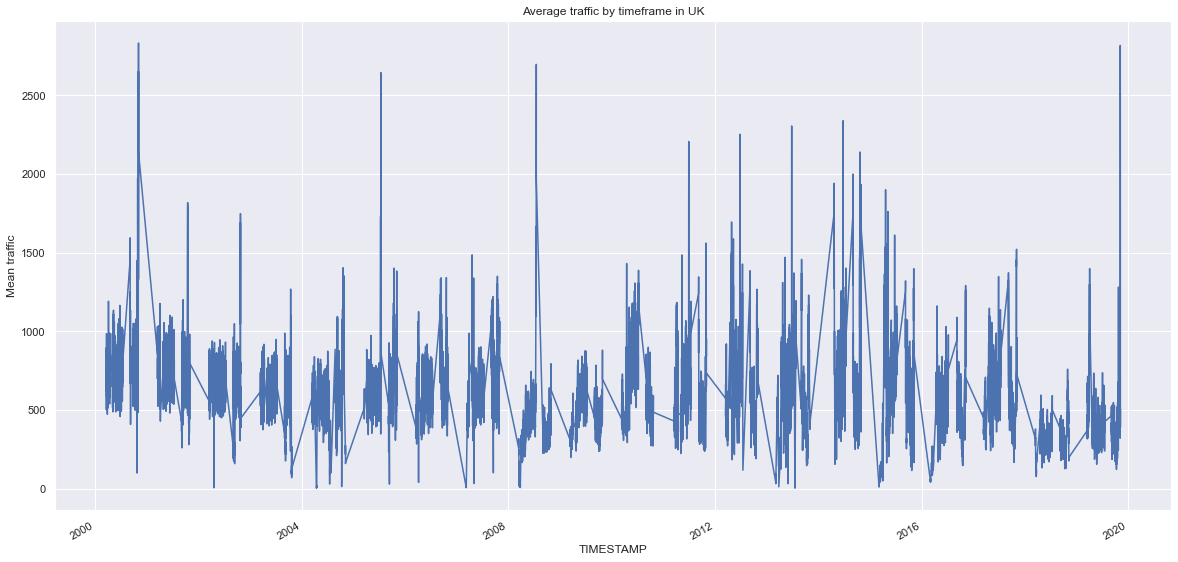

In [76]:
df.groupby('TIMESTAMP')['NUMBER_VEHICLES'].mean().plot(figsize=(20, 10), title='Average traffic by timeframe in UK',ylabel ='Mean traffic')


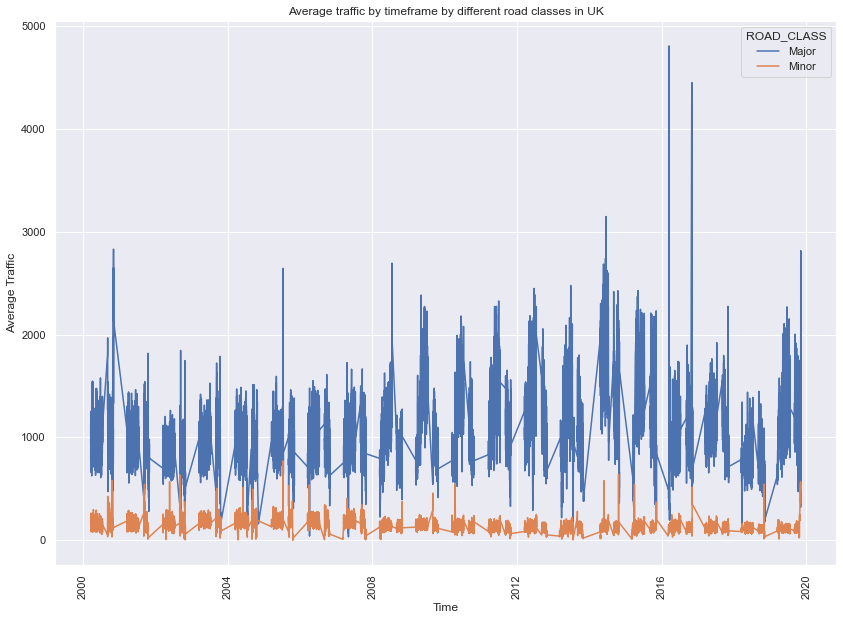

In [77]:
byroadclass2 = df.groupby(['ROAD_CLASS','TIMESTAMP'])['NUMBER_VEHICLES'].mean().reset_index().rename(columns={'NUMBER_VEHICLES':'Mean Traffic'})
sns.set(rc={'figure.figsize':(14,10)})

ax = sns.lineplot(data=byroadclass2, x ='TIMESTAMP', y = 'Mean Traffic',
                  hue='ROAD_CLASS',legend='full')

plt.ylabel('Average Traffic')
plt.title('Average traffic by timeframe by different road classes in UK')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.show()

- Specify to Road ID: The most meaningful prediction

In [78]:
df['ROAD_ID'].value_counts()

C-967547-E-29.3       240
M1-46008-S-88.8       240
M27-6040-E-65.9       240
B781-996074-W-41.3    240
M1-16008-N-88.8       240
                     ... 
U-953264-e-104.6        1
A487-50555-s-16.4       1
A682-56476-w-76.5       1
A606-17289-s-60.2       1
A3102-16955-s-68.1      1
Name: ROAD_ID, Length: 98033, dtype: int64

Plot

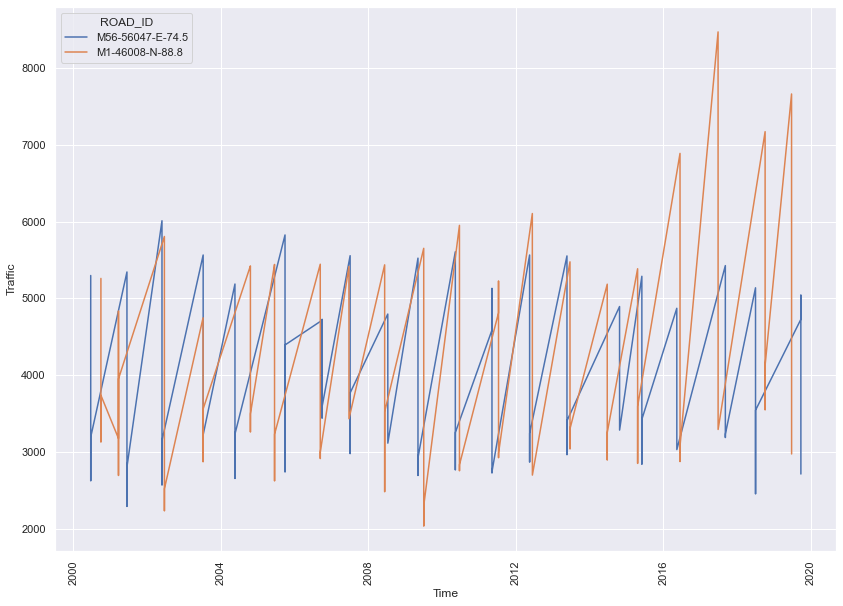

In [79]:
# Subset data
sub1 = df[(df['ROAD_ID']=='M1-46008-N-88.8') | (df['ROAD_ID']=='M56-56047-E-74.5')] 
# Plot
sns.set(rc={'figure.figsize':(14,10)})
ax = sns.lineplot(data=sub1, x ='TIMESTAMP', y = 'NUMBER_VEHICLES',
                  hue='ROAD_ID',legend='full')
plt.ylabel('Traffic')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.show()

***ROAD_CLASS ANALYSIS***

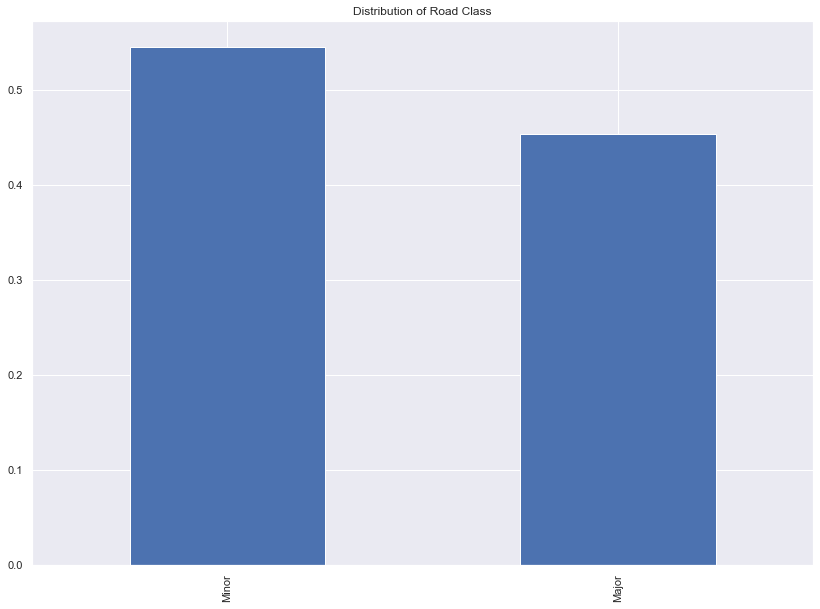

In [80]:
df['ROAD_CLASS'].value_counts(normalize = True).plot(kind='bar')
plt.title('Distribution of Road Class')
plt.show()

***ROAD_ID ANALYSIS***

Filter road IDs with less than 20 records

In [81]:
df.groupby('ROAD_ID').filter(lambda x: len(x) < 20).value_counts()

ROAD_ID               TIMESTAMP            ROAD_CLASS  NUMBER_VEHICLES
U-998071-W-108.6      2008-06-25 18:00:00  Minor       12.0               1
C-800543-N-61.2       2018-06-07 10:00:00  Minor       11.0               1
                      2018-06-07 12:00:00  Minor       5.0                1
                      2018-06-07 13:00:00  Minor       12.0               1
                      2018-06-07 14:00:00  Minor       9.0                1
                                                                         ..
U-805893-N-31.3       2018-09-06 07:00:00  Minor       10.0               1
                      2018-09-06 08:00:00  Minor       15.0               1
                      2018-09-06 09:00:00  Minor       9.0                1
                      2018-09-06 10:00:00  Minor       9.0                1
A1(M)-16062-N-164.11  2016-05-10 07:00:00  Major       1365.0             1
Length: 538031, dtype: int64

Plot them

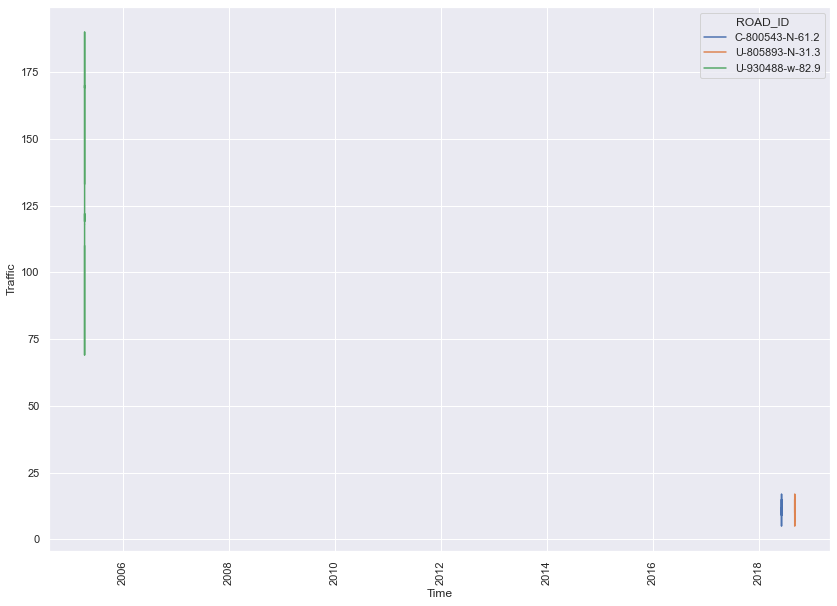

In [82]:
# Subset data
sub2 = df[(df['ROAD_ID']=='C-800543-N-61.2') | (df['ROAD_ID']=='U-805893-N-31.3') | (df['ROAD_ID']=='U-930488-w-82.9')] 
# Plot
sns.set(rc={'figure.figsize':(14,10)})
ax = sns.lineplot(data=sub2, x ='TIMESTAMP', y = 'NUMBER_VEHICLES',
                  hue='ROAD_ID',legend='full')
plt.ylabel('Traffic')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.show()

Important: To predict, all data should be same interval

In [83]:
# Choose a road
df1 = df[df['ROAD_ID']=='M56-56047-E-74.5']
df1 = df1.sort_values(by='TIMESTAMP',ascending=True)
df1

,ROAD_ID,TIMESTAMP,ROAD_CLASS,NUMBER_VEHICLES
4221396,M56-56047-E-74.5,2000-06-20 07:00:00,Major,5298.0
4221397,M56-56047-E-74.5,2000-06-20 08:00:00,Major,4283.0
4221398,M56-56047-E-74.5,2000-06-20 09:00:00,Major,3643.0
4221399,M56-56047-E-74.5,2000-06-20 10:00:00,Major,2626.0
4221400,M56-56047-E-74.5,2000-06-20 11:00:00,Major,2731.0
...,...,...,...,...
100983,M56-56047-E-74.5,2019-09-24 14:00:00,Major,3489.0
100987,M56-56047-E-74.5,2019-09-24 15:00:00,Major,4254.0
100974,M56-56047-E-74.5,2019-09-24 16:00:00,Major,4415.0
100971,M56-56047-E-74.5,2019-09-24 17:00:00,Major,3330.0


In [84]:
# Check on time interval
k = []
for i in range(0,239):
    r = (df1.iloc[i+1,1]-df1.iloc[i,1]).total_seconds() # Calculate gap in seconds
    k.append(r)
Counter(k) # check on frequency

Counter({3600.0: 220,
         30978000.0: 1,
         29941200.0: 1,
         35211600.0: 1,
         27176400.0: 1,
         42814800.0: 1,
         31669200.0: 1,
         23979600.0: 1,
         32187600.0: 2,
         25794000.0: 2,
         31928400.0: 2,
         31323600.0: 1,
         44974800.0: 1,
         19054800.0: 1,
         29854800.0: 1,
         41518800.0: 1,
         38754000.0: 1})

220 intervals of 3600 seconds but there are 19 intervals of different time periods

Text(0.5, 1.0, 'Intervals between timestamp')

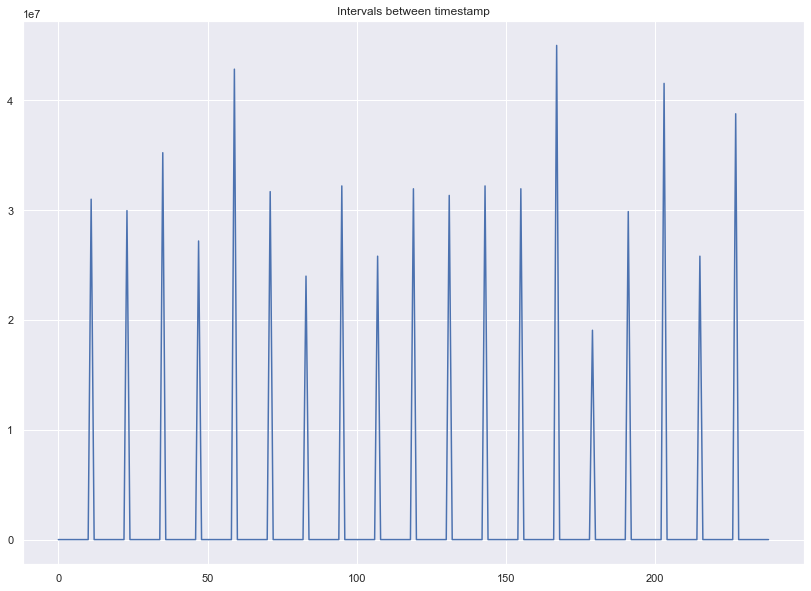

In [85]:
plt.plot(k)
plt.title('Intervals between timestamp')

Intervals are not equally spaced, so they need to be transformed in order to perform time series forecast

**DATA TRANSFORMATION**

***Transform to Complete Data with the Same Time Interval***

In [86]:
print("Latest time frame: " ,max(df['TIMESTAMP']))
print("Earliest time frame: " ,min(df['TIMESTAMP']))

Latest time frame:  2019-11-07 18:00:00
Earliest time frame:  2000-03-17 07:00:00


In [87]:
# Drop unnecessary columns
df1 = df1.drop(columns =['ROAD_ID','ROAD_CLASS'])

In [88]:
df1.iloc[10:15]

,TIMESTAMP,NUMBER_VEHICLES
4221406,2000-06-20 17:00:00,4474.0
4221407,2000-06-20 18:00:00,3196.0
4030256,2001-06-14 07:00:00,5344.0
4030257,2001-06-14 08:00:00,4828.0
4030258,2001-06-14 09:00:00,3373.0


In [89]:
df1.iloc[22:27]

,TIMESTAMP,NUMBER_VEHICLES
4030242,2001-06-14 17:00:00,4252.0
4030243,2001-06-14 18:00:00,2809.0
3828648,2002-05-27 07:00:00,6011.0
3828649,2002-05-27 08:00:00,4928.0
3828650,2002-05-27 09:00:00,3496.0


In [90]:
# Check on time
print("Earliest time frame: " ,min(df1['TIMESTAMP']))
print("Latest time frame: " ,max(df1['TIMESTAMP']))

Earliest time frame:  2000-06-20 07:00:00
Latest time frame:  2019-09-24 18:00:00


What we could see is time starts from 7:00 to 18:00 every day, but in different days. So the author decides to transfrom timestamps to  time period by a range from 1 to 240.

In [91]:
# Create a list of time series
df1['series'] = range(1,241)
df1 = df1.drop(columns =['TIMESTAMP'])
df1

,NUMBER_VEHICLES,series
4221396,5298.0,1
4221397,4283.0,2
4221398,3643.0,3
4221399,2626.0,4
4221400,2731.0,5
...,...,...
100983,3489.0,236
100987,4254.0,237
100974,4415.0,238
100971,3330.0,239


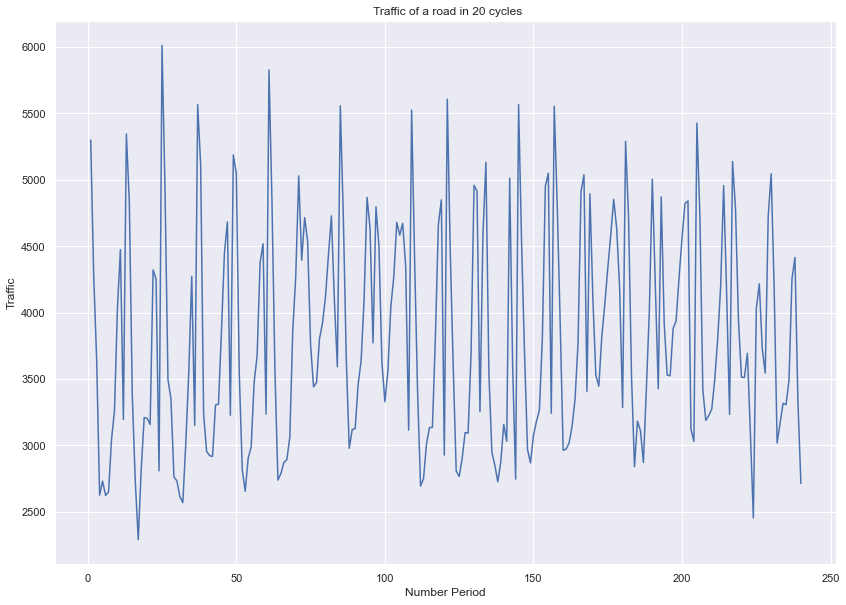

In [92]:
# Visualize data
sns.lineplot(data=df1, x ='series', y = 'NUMBER_VEHICLES')
plt.ylabel('Traffic')
plt.title(' Traffic of a road in 20 cycles')
plt.xlabel('Number Period')
plt.show()

**PART 2: SIMPLE MOVING AVERAGE**

In [93]:
# Set index
df1.set_index('series', inplace=True)

In [94]:
# copy of data to back up
df2 = df1.copy()

In [95]:
# Predict by 3 different periods 3,12 and 30
df1['SMA_3'] = df1.NUMBER_VEHICLES.rolling(3).mean()
df1['SMA_12'] = df1.NUMBER_VEHICLES.rolling(12).mean()
df1['SMA_30'] = df1.NUMBER_VEHICLES.rolling(30).mean()

<function matplotlib.pyplot.show(close=None, block=None)>

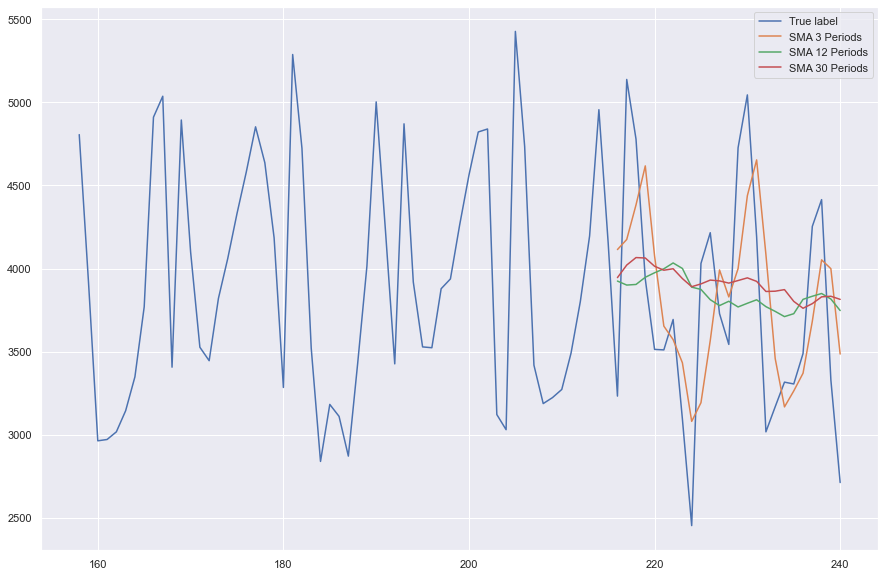

In [96]:
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(df1.loc[158:240,'NUMBER_VEHICLES'],label='True label')
plt.plot(df1.loc[216:240,'SMA_3'],label='SMA 3 Periods')
plt.plot(df1.loc[216:240,'SMA_12'],label='SMA 12 Periods')
plt.plot(df1.loc[216:240,'SMA_30'],label='SMA 30 Periods')
plt.legend()
plt.show

In [98]:
# Performance
print('Mean Absolute Percent Error for SMA(3):', round(np.mean(abs((df1.loc[216:240,'NUMBER_VEHICLES']-df1.loc[216:240,'SMA_3'])/df1.loc[216:240,'NUMBER_VEHICLES']))*100,4),'%')
print('Mean Absolute Percent Error for SMA(12):', round(np.mean(abs((df1.loc[216:240,'NUMBER_VEHICLES']-df1.loc[216:240,'SMA_12'])/df1.loc[216:240,'NUMBER_VEHICLES']))*100,4),'%')
print('Mean Absolute Percent Error for SMA(30):', round(np.mean(abs((df1.loc[216:240,'NUMBER_VEHICLES']-df1.loc[216:240,'SMA_30'])/df1.loc[216:240,'NUMBER_VEHICLES']))*100,4),'%')

Mean Absolute Percent Error for SMA(3): 13.8022 %
Mean Absolute Percent Error for SMA(12): 16.6679 %
Mean Absolute Percent Error for SMA(30): 16.9587 %


**PART 3: ARIMA**

In [99]:
# Split data
train_data = df2.iloc[:216] 
test_data = df2[216:240] # test on 2 circles (24 observations)

****a. Check stationarity****

In [100]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(df1.NUMBER_VEHICLES)   
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -3.203007239950966
p-value: 0.019811266925342273


Reject null hypothesis and conclude that time series is stationary; therefore, there is no need to transform data.

Differencing level: D = 0

****b. Order (p and q) identifying****

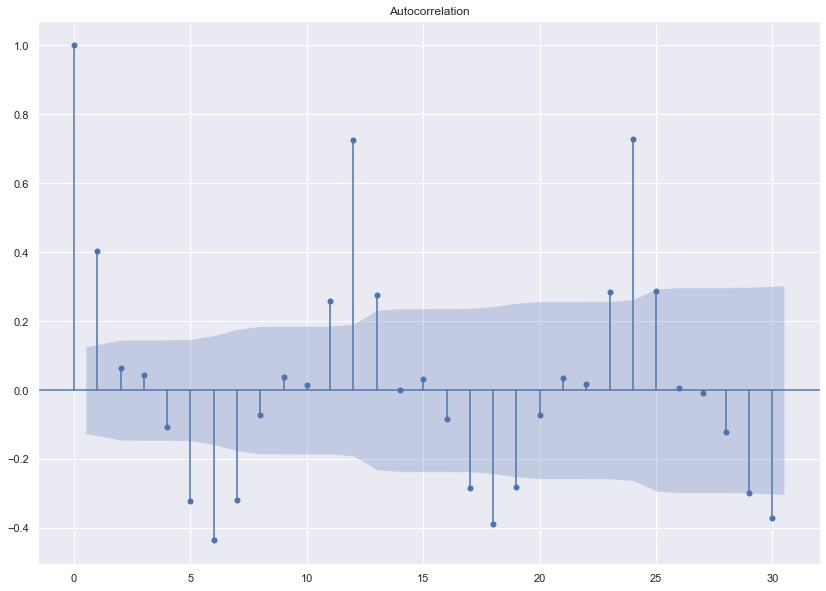

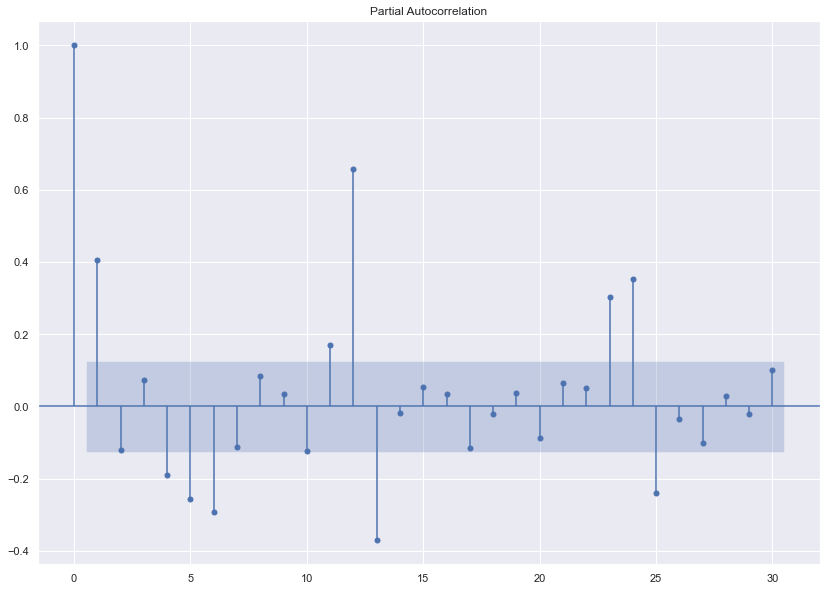

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df1.NUMBER_VEHICLES, lags=30);
plot_pacf(df1.NUMBER_VEHICLES, lags=30, method = "ols");

**AR:**

- AFC has not tailed off (slowly decreased) since it peaks again at 1, 6 and 12.

- PAFC has no significant cut-off, it has several cut off values: 1, 6 12,and 13.

**MA:**

- AFC has no significant cut-off, it has several cut off values: 1, 6 12,and 13.

- PAFC has not tailed off (slowly decreased) since it peaks again at 1, 6 and 12.

It's not appropriate to conduct ARIMA in this case, it is more about SARIMA.
However, let run ARIMA to test on model performance.

Create a function to show all AIC with different combination of order lists

In [105]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

Test on different combinations, in which only d is fixed at 0.

In [106]:
ps = range(0, 13, 1)
d = 0
qs = range(0, 13, 1)
# Create a list with all possible combination of parameters
parameters = itertools.product(ps,qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 0) # insert d in the second position
    each = tuple(each) # convert to tuble
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=train_data['NUMBER_VEHICLES'])
result_df

,"(p, d, q)",AIC
0,"(12, 0, 10)",3293.116889
1,"(12, 0, 11)",3301.508109
2,"(12, 0, 9)",3305.639796
3,"(12, 0, 8)",3305.965064
4,"(12, 0, 6)",3309.552619
...,...,...
164,"(0, 0, 4)",3816.214988
165,"(0, 0, 10)",3822.649373
166,"(0, 0, 2)",3830.561036
167,"(0, 0, 1)",3961.959520


****c. Fit model****

In [108]:
best_model = SARIMAX(train_data['NUMBER_VEHICLES'], order=(12,0,10)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:        NUMBER_VEHICLES   No. Observations:                  216
Model:             SARIMAX(12, 0, 10)   Log Likelihood               -1623.558
Date:                Thu, 20 Oct 2022   AIC                           3293.117
Time:                        23:02:09   BIC                           3370.748
Sample:                             0   HQIC                          3324.480
                                - 216                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0921      0.086      1.074      0.283      -0.076       0.260
ar.L2         -0.1793      0.080     -2.249      0.025      -0.336      -0.023
ar.L3          0.1620      0.086      1.884      0.0

In [109]:
# Predict 
df1['ARIMA_12_0_10'] = best_model.predict(start = 216, end = 240)

<function matplotlib.pyplot.show(close=None, block=None)>

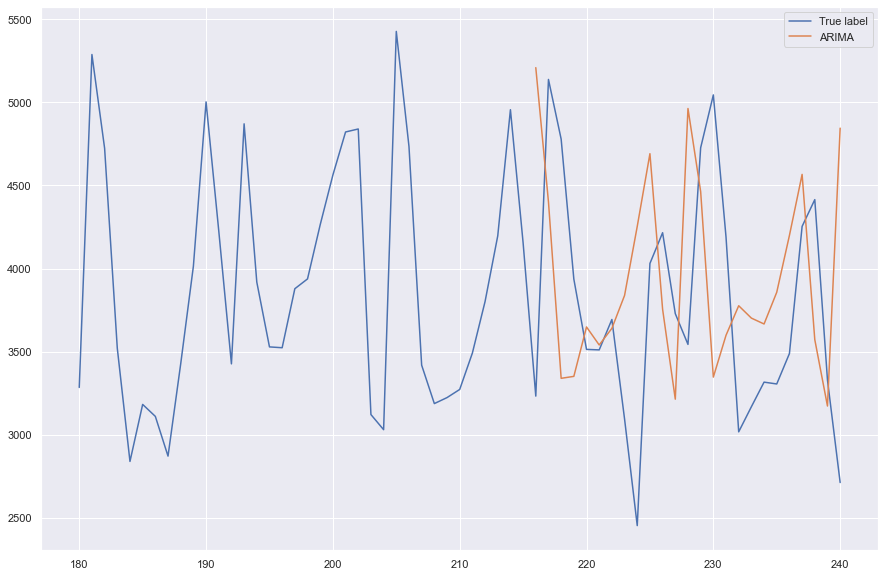

In [110]:
# plot
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(df1.loc[180:240,'NUMBER_VEHICLES'],label='True label')
plt.plot(df1.loc[216:240,'ARIMA_12_0_10'],label='ARIMA')
plt.legend()
plt.show

In [111]:
# Performance
print('Mean Absolute Percent Error for ARIMA:', round(np.mean(abs((df1.loc[216:240,'NUMBER_VEHICLES']-df1.loc[216:240,'ARIMA_12_0_10'])/df1.loc[216:240,'NUMBER_VEHICLES']))*100,4),'%')

Mean Absolute Percent Error for ARIMA: 22.3092 %


<function matplotlib.pyplot.show(close=None, block=None)>

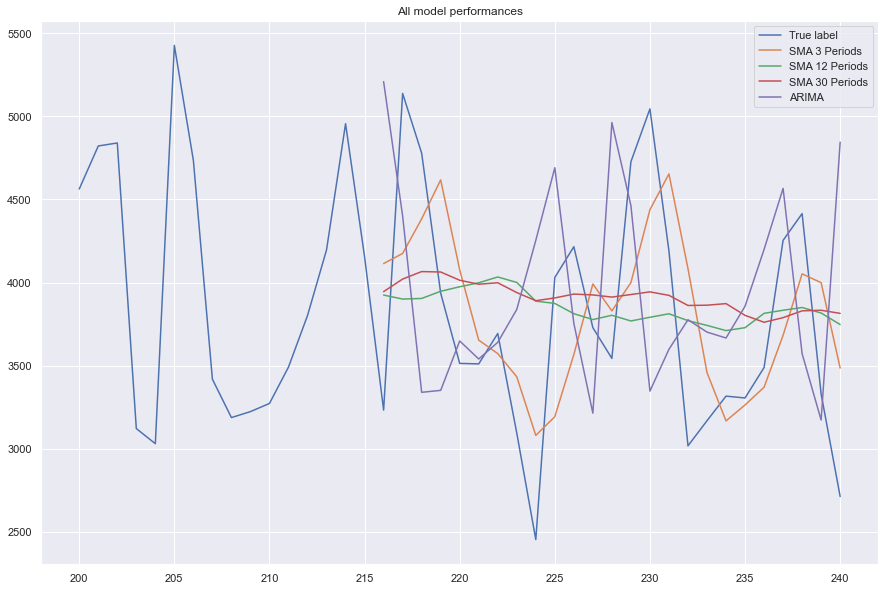

In [112]:
# ALL Model Performance
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(df1.loc[200:240,'NUMBER_VEHICLES'],label='True label')
plt.plot(df1.loc[216:240,'SMA_3'],label='SMA 3 Periods')
plt.plot(df1.loc[216:240,'SMA_12'],label='SMA 12 Periods')
plt.plot(df1.loc[216:240,'SMA_30'],label='SMA 30 Periods')
plt.plot(df1.loc[216:240,'ARIMA_12_0_10'],label='ARIMA')
plt.title('All model performances')
plt.legend()
plt.show

**EXTRA WORKS: SARIMA**

In [115]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [119]:
p = range(0, 4, 1)
d = 0
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 1
parameters = itertools.product(p, q, P, Q)
parameters_list = list(parameters)
result_df2 = optimize_SARIMA(parameters_list, 0, 0, 12, train_data['NUMBER_VEHICLES'])
result_df2

,"(p,q)x(P,Q)",AIC
0,"(0, 2, 2, 1)",12.000000
1,"(2, 2, 1, 1)",14.000000
2,"(0, 1, 2, 3)",14.000000
3,"(2, 2, 0, 2)",14.000000
4,"(2, 3, 0, 1)",14.000000
...,...,...
206,"(0, 0, 0, 1)",3975.411535
207,"(0, 3, 3, 3)",3994.493350
208,"(0, 1, 3, 3)",3994.722010
209,"(0, 2, 3, 3)",3995.698818


In [124]:
best_SARIMA = SARIMAX(train_data['NUMBER_VEHICLES'],order=(0, 0, 2), seasonal_order=(2, 0, 1, 12)).fit()
print(best_SARIMA.summary())

                                      SARIMAX Results                                       
Dep. Variable:                      NUMBER_VEHICLES   No. Observations:                  216
Model:             SARIMAX(0, 1, 2)x(2, 1, [1], 12)   Log Likelihood               -1502.926
Date:                              Thu, 20 Oct 2022   AIC                           3017.851
Time:                                      23:33:28   BIC                           3037.731
Sample:                                           0   HQIC                          3025.894
                                              - 216                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5882      0.063     -9.381      0.000      -0.711      -0.465
ma.L2         -0.32

In [125]:
# Predict 
df1['SARIMA'] = best_SARIMA.predict(start = 216, end = 240)

<function matplotlib.pyplot.show(close=None, block=None)>

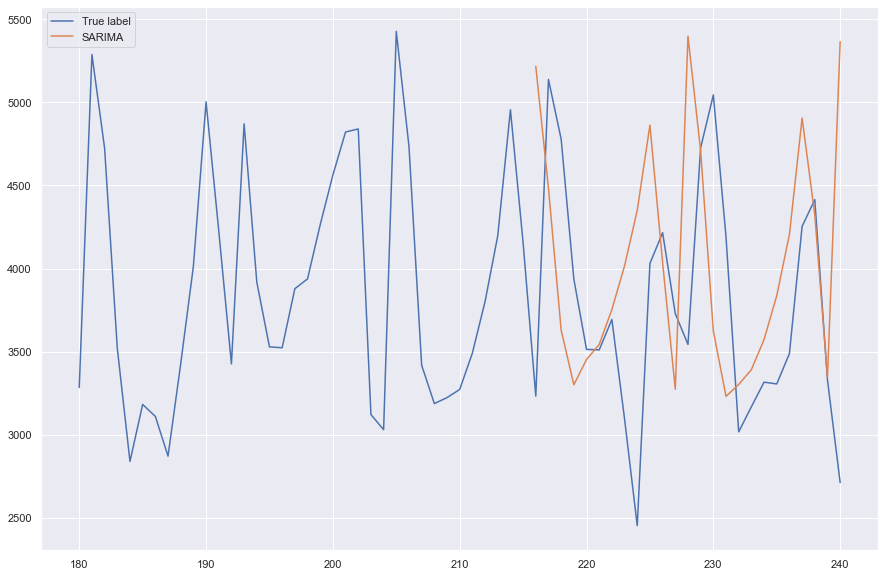

In [126]:
# plot
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(df1.loc[180:240,'NUMBER_VEHICLES'],label='True label')
plt.plot(df1.loc[216:240,'SARIMA'],label='SARIMA')
plt.legend()
plt.show

In [84]:
# Performance
print('Mean Absolute Percent Error for SARIMA:', round(np.mean(abs((df1.loc[216:240,'NUMBER_VEHICLES']-df1.loc[216:240,'SARIMA'])/df1.loc[216:240,'NUMBER_VEHICLES']))*100,4),'%')

Mean Absolute Percent Error for SARIMA: 22.0246 %
